In [1]:
! pip install numba
import numba
from numba import cuda
from numba.cuda.cudadrv import enums
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import time
from numba import vectorize

In [48]:
params = {
    'figure.figsize': [15, 10],  # instead of 4.5, 4.5
    'axes.titlesize': 15,
    'axes.labelsize': 10,
    'axes.linewidth': 0.5,
    'font.size': 20,
    'font.family': 'monospace',
    #    'font.monospace': 'Alma Mono',
    'legend.fontsize': 15,
    'legend.loc': 'upper right',
    'legend.labelspacing': 0.25,
    # 'xtick.labelsize': 20,
    # 'ytick.labelsize': 20,
    'lines.linewidth': 3,
    'text.usetex': False,
    # 'figure.autolayout': True,
    'ytick.right': False,
    'xtick.top': False,

    'xtick.major.size': 5,
    'ytick.major.size': 5,
    'xtick.minor.size': 5,
    'ytick.minor.size': 5,
    'xtick.labelsize': 15,
    'ytick.labelsize': 15,

    'xtick.major.width': 2,
    'ytick.major.width': 2,
    'xtick.minor.width': 1,
    'ytick.minor.width': 1,

    'xtick.major.pad': 2,
    'ytick.major.pad': 2,
    # 'xtick.minor.pad': 14,
    # 'ytick.minor.pad': 14,

    'xtick.direction': 'inout',
    'ytick.direction': 'inout',

    'grid.linestyle': '-',         # solid
    'grid.linewidth': 1.5,        # in points
    'grid.alpha':     1,        # transparency, between 0.0 and 1.0
}
# plt.style.use('fivethirtyeight')
matplotlib.rcParams.update(params)

In [3]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [54]:
#LABWORK6 - 2D KERNEL

Data_path="/content/drive/MyDrive/HPC/"
Image_path=Data_path+"Test_org.jpg"
Image_path=Data_path+"Test_org_2.jpg"
# blockDim.x,y,z gives the number of threads in a block, in the particular direction
# gridDim.x,y,z gives the number of blocks in a grid, in the particular direction
# blockDim.x * gridDim.x gives the number of threads in a grid


# Mapping
@cuda.jit
def grayscale(src, dst, threshold):
  print("test")
  tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
  tidy = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y
  g = np.uint8(src[tidx,tidy, 0] + src[tidx,tidy, 1] + src[tidx,tidy, 2]) / 3
  print(g)
  print(threshold)
  if g >= threshold:
    g = 1
  else:
    g = 0
  dst[tidx,tidy, 0] = dst[tidx,tidy, 1] = dst[tidx,tidy, 2] = g

@cuda.jit
def brightness(src, dst, scale):
  tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
  tidy = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y
  for i in range(3):
    dst[tidx,tidy,i] = src[tidx,tidy,i] + scale

@cuda.jit
def Mapping_2(src,dst,weight,src_2):
  def blend(weight):
    tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    tidy = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y
    c = weight
    if c <= 1:
      raise KeyError("Please check you input again")
    else:
      for i in range(3):
        dst[tidx, tidy, i] = src[tidx, tidy, i] * c + src_2[tidx, tidy, i] * (1 - c)

# Image data
img_data=plt.imread(Image_path)

# Shape of the figure
(imageHeight,imageWidth,_)=img_data.shape
pixelCount = imageWidth * imageHeight
out_img = np.array(img_data, copy=True)


def compare(blockSize, function, threshold = 100, scale = 5, weight = 0.5, output=False, Image_path_2 = False):
  #Grid size -> chunk
  #int to ensure it's an interger
  # BlockSize should be the multiplication of 32
  grid_1 = int(imageHeight/blockSize)
  grid_2 = int(imageWidth/blockSize)
  print(grid_1,grid_2)
  gridSize=(grid_1,grid_2)

  blockSize=(blockSize,blockSize)

  # Start timing
  start_time=time.time()

  # Copy image to the device from host(CPU)
  devSrc = cuda.to_device(img_data)


  # Allocate memory on the device (GPU)
  devDst = cuda.device_array((imageHeight,imageWidth,3), np.uint8)

  if Image_path_2 is False:
    if function == 1:
      grayscale[gridSize,blockSize](devSrc, devDst, threshold)
    else:
      brightness[gridSize,blockSize](devSrc, devDst, scale)
  else:
    function = 3
    # Image data
    img_data_2=plt.imread(Image_path_2)

    # Shape of the figure
    (imageHeight_2,imageWidth_2,_)=img_data_2.shape
    pixelCount = imageWidth_2 * imageHeight_2
    grid_1 = int(imageHeight_2/blockSize)
    grid_2 = int(imageWidth_2/blockSize)
    print(grid_1,grid_2)
    gridSize_2=(grid_1,grid_2)
    devSrc_2 = cuda.to_device(img_data_2)

    Mapping_2[gridSize,blockSize](devSrc, devDst, function, threshold, scale, weight, devSrc_2)


  #Copy from device to host
  hostDst = devDst.copy_to_host()

  # Stop timing
  end_time=time.time()

  #Get the running time
  run_time=end_time-start_time

  if output == True:
    return run_time, hostDst
  else: return run_time

1
67 120
(1082, 1920, 3)
(1082, 1920, 3)
The run time is 0.006941080093383789 s
1082 1920
The runtime for the blockSize 1 is 0.012190580368041992
541 960
The runtime for the blockSize 2 is 0.00648188591003418
270 480
The runtime for the blockSize 4 is 0.0057528018951416016
135 240
The runtime for the blockSize 8 is 0.005609035491943359
67 120
The runtime for the blockSize 16 is 0.0060122013092041016


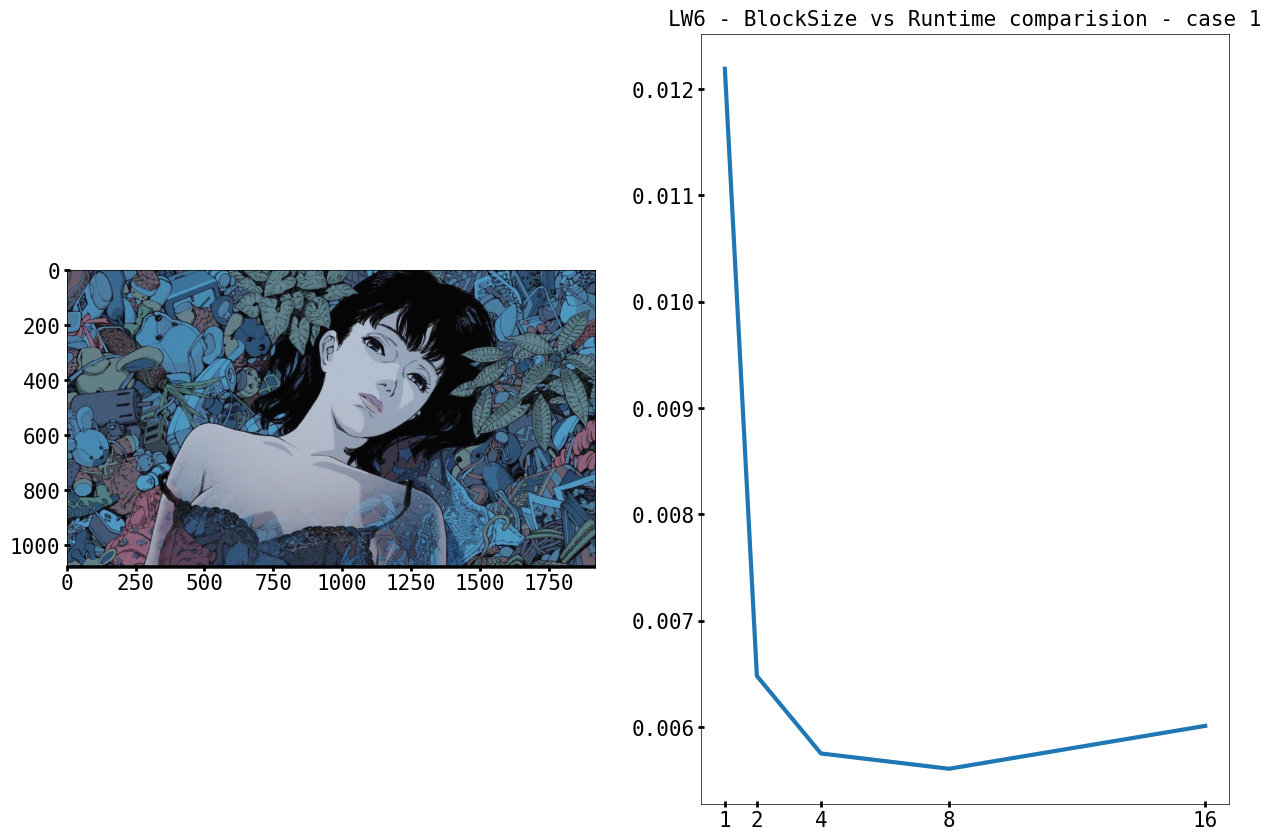

In [58]:
#Output run_time and hostDst
function = input()

plt.subplot(1,2,1)
#Individual case
blockSize = 16
run_time,hostDst = compare(blockSize, function, output=True)

# Show the resule image
print(img_data.shape)
print(hostDst.shape)
plt.imshow(hostDst)
# Save the image
plt.savefig(f'{Data_path}Test_result_LW6_case_{function}.jpg')
print("The run time is",run_time,"s")

plt.subplot(1,2,2)
#Comparision case
runtime_list=[]
blockSize_final=[]
blockSize_label=[]
for i in range(0,5):
  blockSize=2**i
  run_time=compare(blockSize,function, output = False)
  runtime_list.append(run_time)
  blockSize_final.append(blockSize)
  blockSize_label.append(str(blockSize))
  print(f"The runtime for the blockSize {blockSize} is {run_time}")

name=f'LW6 - BlockSize vs Runtime comparision - case {function}' # - Shared memory')
plt.plot(blockSize_final,runtime_list)
plt.xticks(blockSize_final,blockSize_label)
plt.title(name) #- Shared memory")
plt.savefig(Data_path + name + ",png")